=== Baseline 5-Fold CV ===

-- original (train shape: (343, 68)) --
LogisticRegression Fold1: Acc=0.8551 F1=0.7064 Rec=0.7375
LogisticRegression Fold2: Acc=0.8986 F1=0.7582 Rec=0.7744
LogisticRegression Fold3: Acc=0.9275 F1=0.8267 Rec=0.7914
LogisticRegression Fold4: Acc=0.9118 F1=0.7896 Rec=0.8244
LogisticRegression Fold5: Acc=0.9412 F1=0.8643 Rec=0.8292
LogisticRegression Avg → Acc=0.9068, F1=0.7891, Rec=0.7914

RandomForest Fold1: Acc=0.8696 F1=0.7467 Rec=0.7458
RandomForest Fold2: Acc=0.9130 F1=0.7848 Rec=0.7414
RandomForest Fold3: Acc=0.9130 F1=0.7691 Rec=0.7414
RandomForest Fold4: Acc=0.9265 F1=0.8188 Rec=0.7789
RandomForest Fold5: Acc=0.8824 F1=0.7397 Rec=0.7119
RandomForest Avg → Acc=0.9009, F1=0.7718, Rec=0.7439

GradientBoosting Fold1: Acc=0.8261 F1=0.6852 Rec=0.6792
GradientBoosting Fold2: Acc=0.9130 F1=0.7848 Rec=0.7414
GradientBoosting Fold3: Acc=0.9130 F1=0.8022 Rec=0.7417
GradientBoosting Fold4: Acc=0.8676 F1=0.7276 Rec=0.7447
GradientBoosting Fold5: Acc=0.8971 F1=0.7921

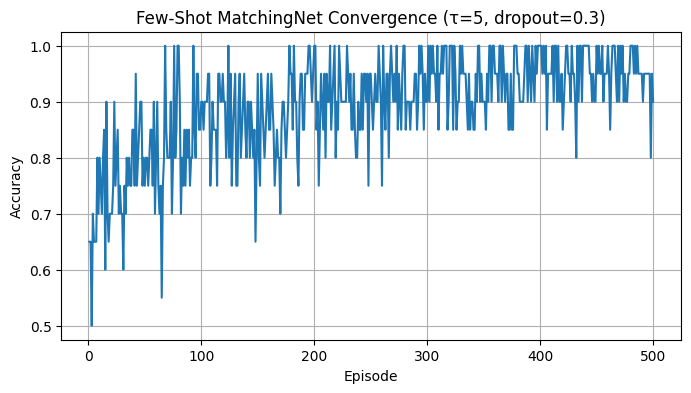


Average Episodic Accuracy: 0.8925


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score
)

# --- Config & Seed ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- Data files ---
dataset_files = {
    'original':   ('/content/sample_data/train_original.csv',    '/content/sample_data/test_original.csv'),
    'pca':        ('/content/sample_data/train_pca.csv',         '/content/sample_data/test_pca.csv'),
    'smote':      ('/content/sample_data/train_smote.csv',       '/content/sample_data/test_smote.csv'),
    'smote_pca':  ('/content/sample_data/train_smote_pca.csv',   '/content/sample_data/test_smote_pca.csv'),
    'default':    ('/content/sample_data/train.csv',             '/content/sample_data/test.csv'),
}

# --- Utility: Load & Preprocess ---
def load_and_prepare(name):
    train_fp, test_fp = dataset_files[name]
    df_tr = pd.read_csv(train_fp, index_col=0)
    df_te = pd.read_csv(test_fp,  index_col=0)
    # detect label column
    for col in ['failure mode','FailureMode','Failure Mode','failure_mode']:
        if col in df_tr.columns:
            target = col
            break
    else:
        raise KeyError(f"[{name}] no label column in {train_fp}")
    # features + labels
    X_tr = df_tr.drop(columns=[target]).values
    y_tr = df_tr[target].values - 1
    X_te = df_te.drop(columns=[target]).values
    y_te = df_te[target].values - 1
    # SMOTE if needed
    if name in ('smote','smote_pca'):
        X_tr, y_tr = SMOTE(random_state=SEED).fit_resample(X_tr, y_tr)
    # PCA if needed
    if name in ('pca','smote_pca'):
        pca = PCA(n_components=0.95, random_state=SEED)
        X_tr = pca.fit_transform(X_tr)
        X_te = pca.transform(X_te)
    return X_tr, y_tr, X_te, y_te

#  Baseline 5-Fold CV ---
print("=== Baseline 5-Fold CV ===")
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=SEED),
    'RandomForest':       RandomForestClassifier(n_estimators=100, random_state=SEED),
    'GradientBoosting':   GradientBoostingClassifier(n_estimators=100, random_state=SEED),
}

for name in dataset_files:
    X_tr, y_tr, _, _ = load_and_prepare(name)
    print(f"\n-- {name} (train shape: {X_tr.shape}) --")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for mname, model in models.items():
        accs, f1s, recs = [], [], []
        for fold, (i_train, i_val) in enumerate(skf.split(X_tr, y_tr), 1):
            model.fit(X_tr[i_train], y_tr[i_train])
            preds = model.predict(X_tr[i_val])
            accs.append(accuracy_score(y_tr[i_val], preds))
            f1s.append(f1_score(y_tr[i_val], preds, average='macro'))
            recs.append(recall_score(y_tr[i_val], preds, average='macro'))
            print(f"{mname} Fold{fold}: Acc={accs[-1]:.4f} F1={f1s[-1]:.4f} Rec={recs[-1]:.4f}")
        print(f"{mname} Avg → Acc={np.mean(accs):.4f}, F1={np.mean(f1s):.4f}, Rec={np.mean(recs):.4f}\n")

# Few-Shot Convergence with Best Hyperparams ---

def create_episode(X, y, k_sup=5, k_qry=5, n_cls=4):
    sx, sy, qx, qy = [], [], [], []
    for c in range(n_cls):
        idx = np.where(y == c)[0]
        np.random.shuffle(idx)
        sup, qry = idx[:k_sup], idx[k_sup:k_sup+k_qry]
        sx.append(X[sup]); sy.append(y[sup])
        qx.append(X[qry]); qy.append(y[qry])
    return (
        torch.tensor(np.vstack(sx), dtype=torch.float),
        torch.tensor(np.hstack(sy), dtype=torch.long),
        torch.tensor(np.vstack(qx), dtype=torch.float),
        torch.tensor(np.hstack(qy), dtype=torch.long)
    )

# MatchingNet with best params
class EmbeddingNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, embed_dim, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.drop = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.drop(x)
        return self.fc2(x)

class MatchingNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, embed_dim, n_cls, temp=5.0, dropout_rate=0.3):
        super().__init__()
        self.embed = EmbeddingNet(in_dim, hidden_dim, embed_dim, dropout_rate)
        self.temp = temp
        self.n_cls = n_cls
    def forward(self, sx, sy, qx):
        se = F.normalize(self.embed(sx), p=2, dim=1)
        qe = F.normalize(self.embed(qx), p=2, dim=1)
        sims = torch.matmul(qe, se.t()) * self.temp
        attn = F.softmax(sims, dim=1)
        oh = F.one_hot(sy, num_classes=self.n_cls).float()
        return torch.matmul(attn, oh)

# Prepare SMOTE+PCA data
X_raw, y_raw = load_and_prepare('smote_pca')[:2]
X_sm, y_sm   = SMOTE(random_state=SEED).fit_resample(X_raw, y_raw)
pca          = PCA(n_components=0.95, random_state=SEED)
X_all        = pca.fit_transform(X_sm)
y_all        = y_sm

# Instantiate & train for many episodes
model         = MatchingNet(X_all.shape[1], 128, 64, 4, temp=5.0, dropout_rate=0.3)
opt           = optim.Adam(model.parameters(), lr=1e-3)
crit          = nn.CrossEntropyLoss()
NUM_EPISODES  = 500
k_support, k_query = 5, 5

episode_accs = []
model.train()
for ep in range(1, NUM_EPISODES+1):
    sx, sy, qx, qy = create_episode(X_all, y_all, k_support, k_query)
    opt.zero_grad()
    out = model(sx, sy, qx)
    loss = crit(out, qy)
    loss.backward()
    opt.step()
    with torch.no_grad():
        preds = out.argmax(1)
        episode_accs.append((preds == qy).float().mean().item())
    if ep % 100 == 0:
        print(f"Episode {ep}/{NUM_EPISODES} → Acc={episode_accs[-1]:.4f}")

# Plot convergence
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, NUM_EPISODES+1), episode_accs, label='Accuracy')
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.title("Few-Shot MatchingNet Convergence (τ=5, dropout=0.3)")
plt.grid(True)
plt.show()

print(f"\nAverage Episodic Accuracy: {np.mean(episode_accs):.4f}")


Episode 100/500 → Acc=0.9000, F1=0.8958, Rec=0.9000
Episode 200/500 → Acc=1.0000, F1=1.0000, Rec=1.0000
Episode 300/500 → Acc=1.0000, F1=1.0000, Rec=1.0000
Episode 400/500 → Acc=1.0000, F1=1.0000, Rec=1.0000
Episode 500/500 → Acc=1.0000, F1=1.0000, Rec=1.0000

Average Episodic Accuracy : 0.9627
Average Episodic Macro-F1 : 0.9618
Average Episodic Recall   : 0.9627


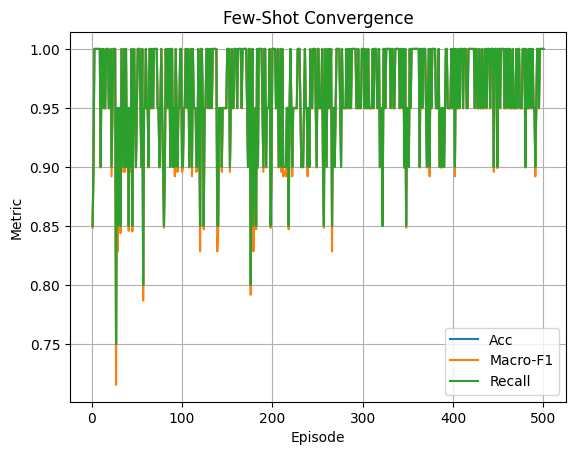


=== Final Test-Set Performance ===

Classification Report:
              precision    recall  f1-score   support

           0     0.8750    0.9459    0.9091        37
           1     0.6000    0.5000    0.5455         6
           2     0.9429    0.8684    0.9041        38
           3     0.6667    0.8000    0.7273         5

    accuracy                         0.8721        86
   macro avg     0.7711    0.7786    0.7715        86
weighted avg     0.8737    0.8721    0.8709        86

Accuracy    : 0.8721
Macro-F1    : 0.7715
Macro-Recall: 0.7786


In [ ]:
from sklearn.metrics import f1_score, recall_score


model.train()

episode_accs = []
episode_f1s  = []
episode_recs = []

for ep in range(1, NUM_EPISODES+1):
    sx, sy, qx, qy = create_episode(X_all, y_all, k_support, k_query)
    opt.zero_grad()
    out = model(sx, sy, qx)
    loss = crit(out, qy)
    loss.backward()
    opt.step()

    with torch.no_grad():
        preds = out.argmax(1)
        acc = (preds == qy).float().mean().item()

        f1  = f1_score(qy.cpu().numpy(), preds.cpu().numpy(), average='macro')
        rec = recall_score(qy.cpu().numpy(), preds.cpu().numpy(), average='macro')

    episode_accs.append(acc)
    episode_f1s.append(f1)
    episode_recs.append(rec)

    if ep % 100 == 0:
        print(f"Episode {ep}/{NUM_EPISODES} → Acc={acc:.4f}, F1={f1:.4f}, Rec={rec:.4f}")


print(f"\nAverage Episodic Accuracy : {np.mean(episode_accs):.4f}")
print(f"Average Episodic Macro-F1 : {np.mean(episode_f1s):.4f}")
print(f"Average Episodic Recall   : {np.mean(episode_recs):.4f}")

plt.plot(range(1, NUM_EPISODES+1), episode_accs, label='Acc')
plt.plot(range(1, NUM_EPISODES+1), episode_f1s,  label='Macro-F1')
plt.plot(range(1, NUM_EPISODES+1), episode_recs, label='Recall')
plt.xlabel("Episode"); plt.ylabel("Metric")
plt.legend(); plt.title("Few-Shot Convergence"); plt.grid(True)
plt.show()

_, _, X_te_raw, y_te_raw = load_and_prepare('smote_pca')
X_te = pca.transform(X_te_raw)
y_te = y_te_raw


te_x = torch.tensor(X_te, dtype=torch.float)

sup_x = torch.tensor(X_all, dtype=torch.float)
sup_y = torch.tensor(y_all, dtype=torch.long)


model.eval()
with torch.no_grad():
    out_te = model(sup_x, sup_y, te_x)
    preds = out_te.argmax(1).cpu().numpy()

acc_test       = accuracy_score(y_te, preds)
f1_test        = f1_score(y_te, preds, average='macro')
recall_test    = recall_score(y_te, preds, average='macro')

print("\n=== Final Test-Set Performance ===")

print("\nClassification Report:")
print(classification_report(y_te, preds, digits=4))
print(f"Accuracy    : {acc_test:.4f}")
print(f"Macro-F1    : {f1_test:.4f}")
print(f"Macro-Recall: {recall_test:.4f}")


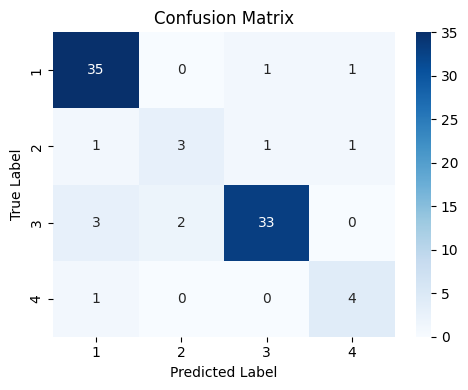

In [ ]:
# after loading and preprocessing…

model.eval()
with torch.no_grad():
    out_te = model(sup_x, sup_y, te_x)
    preds = out_te.argmax(1).cpu().numpy()

y_true = y_te_raw  # numpy array of true labels 0–3
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# make sure these variables exist:
#   y_true: numpy array of shape (n_samples,)
#   preds:  numpy array of shape (n_samples,)
cm = confusion_matrix(y_true, preds, labels=[0,1,2,3])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


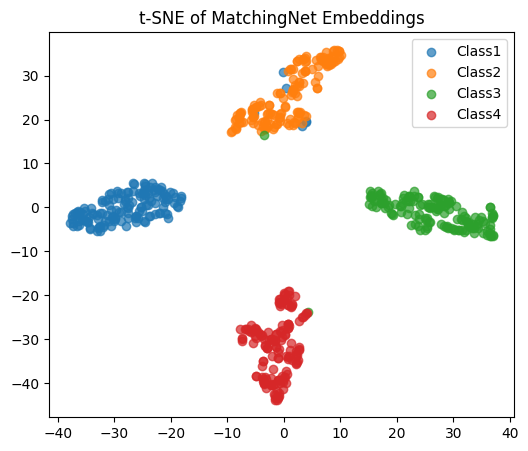

In [ ]:
from sklearn.manifold import TSNE

embeds = model.embed(torch.tensor(X_all, dtype=torch.float)).detach().numpy()
tsne = TSNE(n_components=2, random_state=42).fit_transform(embeds)
plt.figure(figsize=(6,5))
for c in range(4):
    plt.scatter(tsne[y_all==c,0], tsne[y_all==c,1], label=f"Class{c+1}", alpha=0.7)
plt.legend(); plt.title("t-SNE of MatchingNet Embeddings")
plt.show()


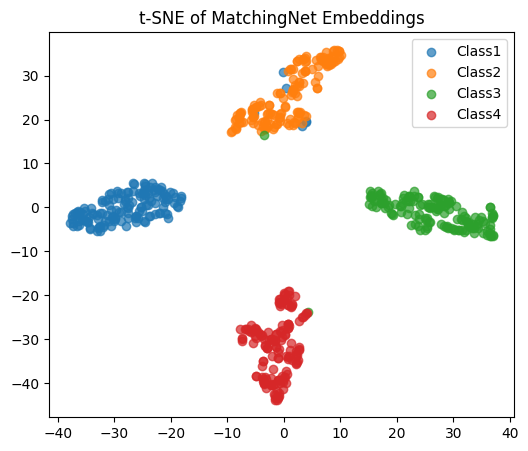

In [ ]:
from sklearn.manifold import TSNE

embeds = model.embed(torch.tensor(X_all, dtype=torch.float)).detach().numpy()
tsne = TSNE(n_components=2, random_state=42).fit_transform(embeds)
plt.figure(figsize=(6,5))
for c in range(4):
    plt.scatter(tsne[y_all==c,0], tsne[y_all==c,1], label=f"Class{c+1}", alpha=0.7)
plt.legend(); plt.title("t-SNE of MatchingNet Embeddings")
plt.show()
